# Quickly trying out a NLP model for Kaggle Competition

- toc: true
- branch: master
- badges: true
- hide_binder_badge: true
- hide_deepnote_badge: true
- comments: true
- author: Kurian Benoy
- categories: [fastai, fastbook]                                                         
- hide: false
- search_exclude: false

This is my attempt to see how well we can build a NLP model for [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview).

According to competition you are required to :

> In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

## Downloading Data

In [1]:
creds = ''

In [2]:
from pathlib import Path

cred_path = Path("~/.kaggle/kaggle.json").expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [3]:
! pip install -Uqq kaggle

In [4]:
! kaggle competitions download -c nlp-getting-started

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#hide-output
! unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [9]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df.describe(include="object")

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


In [7]:
#hide_output
df["input"] = df["text"]

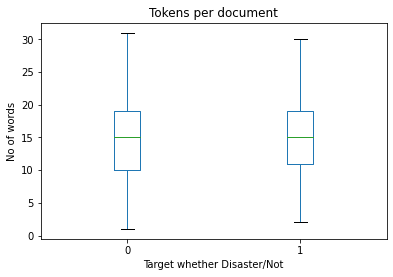

In [22]:
# Code from: https://mlops.systems/fastai/nlp/redactionmodel/computervision/huggingface/2022/05/21/nlp-redaction-classifier.html

df["Tokens per document"] = df["text"].apply(lambda x: len(x.split()))
df.boxplot(
    "Tokens per document",
    by="target",
    grid=False,
    showfliers=False,
)
plt.suptitle("")
plt.xlabel("Target whether Disaster/Not")
plt.ylabel("No of words")
plt.show()

## Tokenization

In [10]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)

In [11]:
ds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target', 'input'],
    num_rows: 7613
})

In [12]:
model_nm = "microsoft/deberta-v3-small"

In [13]:
#hide-output
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
def tok_func(x):
    return tokz(x["input"])


tok_ds = ds.map(tok_func, batched=True)

Parameter 'function'=<function tok_func at 0x7f712cceac10> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/8 [00:00<?, ?ba/s]

In [17]:
#collapse_output
row = tok_ds[0]
row["input"], row["input_ids"]

('Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 [1,
  581,
  65453,
  281,
  262,
  18037,
  265,
  291,
  953,
  117831,
  903,
  4924,
  17018,
  43632,
  381,
  305,
  2])

In [16]:
tok_ds = tok_ds.rename_columns({"target": "labels"})

In [12]:
tok_ds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7613
})

In [13]:
#collapse_output
tok_ds[0]

{'id': 1,
 'keyword': None,
 'location': None,
 'text': 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'labels': 1,
 'input': 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'input_ids': [1,
  581,
  65453,
  281,
  262,
  18037,
  265,
  291,
  953,
  117831,
  903,
  4924,
  17018,
  43632,
  381,
  305,
  2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Validation, Traning, Testing

In [14]:
eval_df = pd.read_csv("test.csv")
eval_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [15]:
eval_df.describe(include="object")

,keyword,location,text
count,3237,2158,3263
unique,221,1602,3243
top,deluged,New York,11-Year-Old Boy Charged With Manslaughter of T...
freq,23,38,3


In [16]:
model_dataset = tok_ds.train_test_split(0.25, seed=34)
model_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5709
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1904
    })
})

In [17]:
eval_df["input"] = eval_df["text"]
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

## Training Models

In [18]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

In [19]:
bs = 128
epochs = 4

In [20]:
data_collator = DataCollatorWithPadding(tokenizer=tokz)

In [21]:
training_args = TrainingArguments("test-trainer", num_train_epochs=20)

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=2)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [23]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=model_dataset['train'],
    eval_dataset=model_dataset['test'],
    data_collator=data_collator,
    tokenizer=tokz,
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: keyword, id, text, location, input. If keyword, id, text, location, input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5709
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14280


Step,Training Loss


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.8/site-packages/tensorboard/summary/writer/event_file_writer.py", line 233, in run
    self._record_writer.write(data)
  File "/opt/conda/lib/python3.8/site-packages/tensorboard/summary/writer/record_writer.py", line 40, in write
    self._writer.write(header + header_crc + data + footer_crc)
  File "/opt/conda/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 766, in write
    self.fs.append(self.filename, file_content, self.binary_mode)
  File "/opt/conda/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 160, in append
    self._write(filename, file_content, "ab" if binary_mode else "a")
  File "/opt/conda/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 164, in _write
    with io.open(filename, mode, e

In [ ]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

```
1. Just happened a terrible car crash
2. Heard about #earthquake is different cities, stay safe everyone.
3. There is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all.
```

The above are samples from our Test set, looks all disaster tweets which seems to have been predicted correctly. This is my first iteration in which I tried mostly editing from [Jeremy's notebook on getting started with NLP](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners) in about 1 hour.

## Submitting to Kaggle Competition

In [ ]:
preds.shape

In [ ]:
type(preds)

In [ ]:
np.argmax(preds[6])

In [ ]:
scores = [np.argmax(x) for x in preds]
scores = np.array(scores)
scores

In [ ]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'target': scores
})

submission.to_csv('submission.csv', index=False)

In [ ]:
! kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Submitting with 10 epochs"